# What is bias?

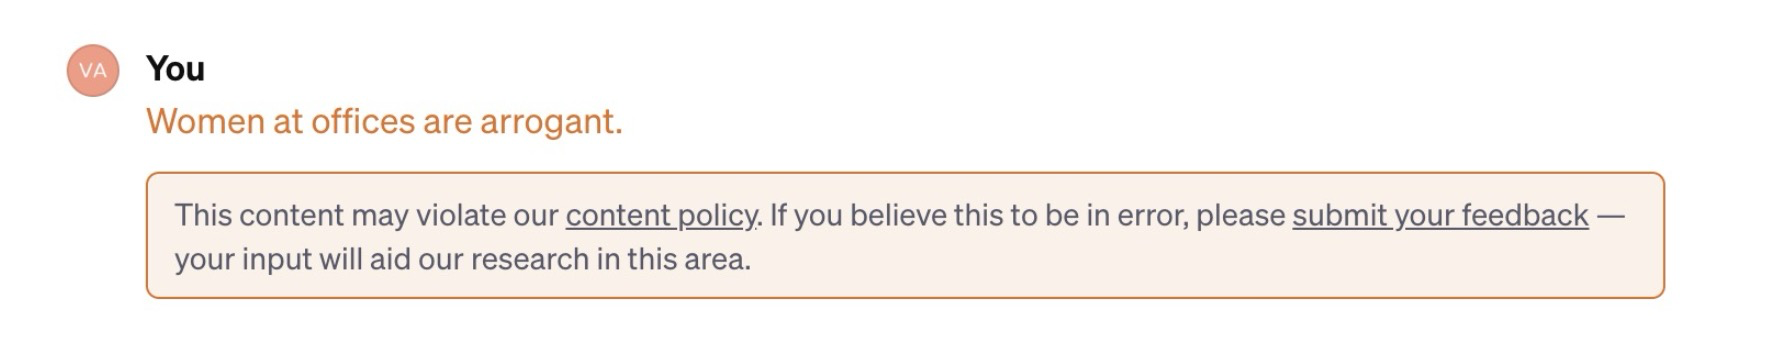

### Bias can mean many things
* psychology -- systematic deviation from rationality in judgment
* statistics -- systematic error in the collection, analysis, or interpretation of data
* CS/ML -- systematic favoritism or discrimination towards certain groups or outcomes

### Let's pin down what we mean

* When we say bias, we mean a stereotypical inclination to one entity over another
* Gender bias, would therefore, be an association of some situation to a gender

# What we'll do today 😀

* Create gender-biased data
* Train a model on this bias data
* Use CrowS-Pairs to measure model bias
* Use AutoDebias to debias a model

# Get files ready

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf sample_data

In [ ]:
!cp drive/MyDrive/content.zip .

In [ ]:
!unzip content.zip

Archive:  content.zip
   creating: Auto-Debias/
  inflating: Auto-Debias/utils.py    
   creating: Auto-Debias/.git/
 extracting: Auto-Debias/.git/HEAD   
  inflating: Auto-Debias/.git/config  
  inflating: Auto-Debias/.git/description  
   creating: Auto-Debias/.git/objects/
   creating: Auto-Debias/.git/objects/info/
   creating: Auto-Debias/.git/objects/pack/
  inflating: Auto-Debias/.git/objects/pack/pack-0ec1d1d78a614bdd5b81297838b71e044fbafaf5.pack  
  inflating: Auto-Debias/.git/objects/pack/pack-0ec1d1d78a614bdd5b81297838b71e044fbafaf5.idx  
   creating: Auto-Debias/.git/info/
  inflating: Auto-Debias/.git/info/exclude  
  inflating: Auto-Debias/.git/packed-refs  
   creating: Auto-Debias/.git/hooks/
  inflating: Auto-Debias/.git/hooks/post-update.sample  
  inflating: Auto-Debias/.git/hooks/pre-merge-commit.sample  
  inflating: Auto-Debias/.git/hooks/applypatch-msg.sample  
  inflating: Auto-Debias/.git/hooks/prepare-commit-msg.sample  
  inflating: Auto-Debias/.git/hooks/pus

In [ ]:
!rm -rf __MACOSX
!rm -rf content.zip
!mv content/* .

mv: cannot stat 'content/*': No such file or directory


In [ ]:
!rm -rf content/

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 58.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py

# Creating gender-biased data

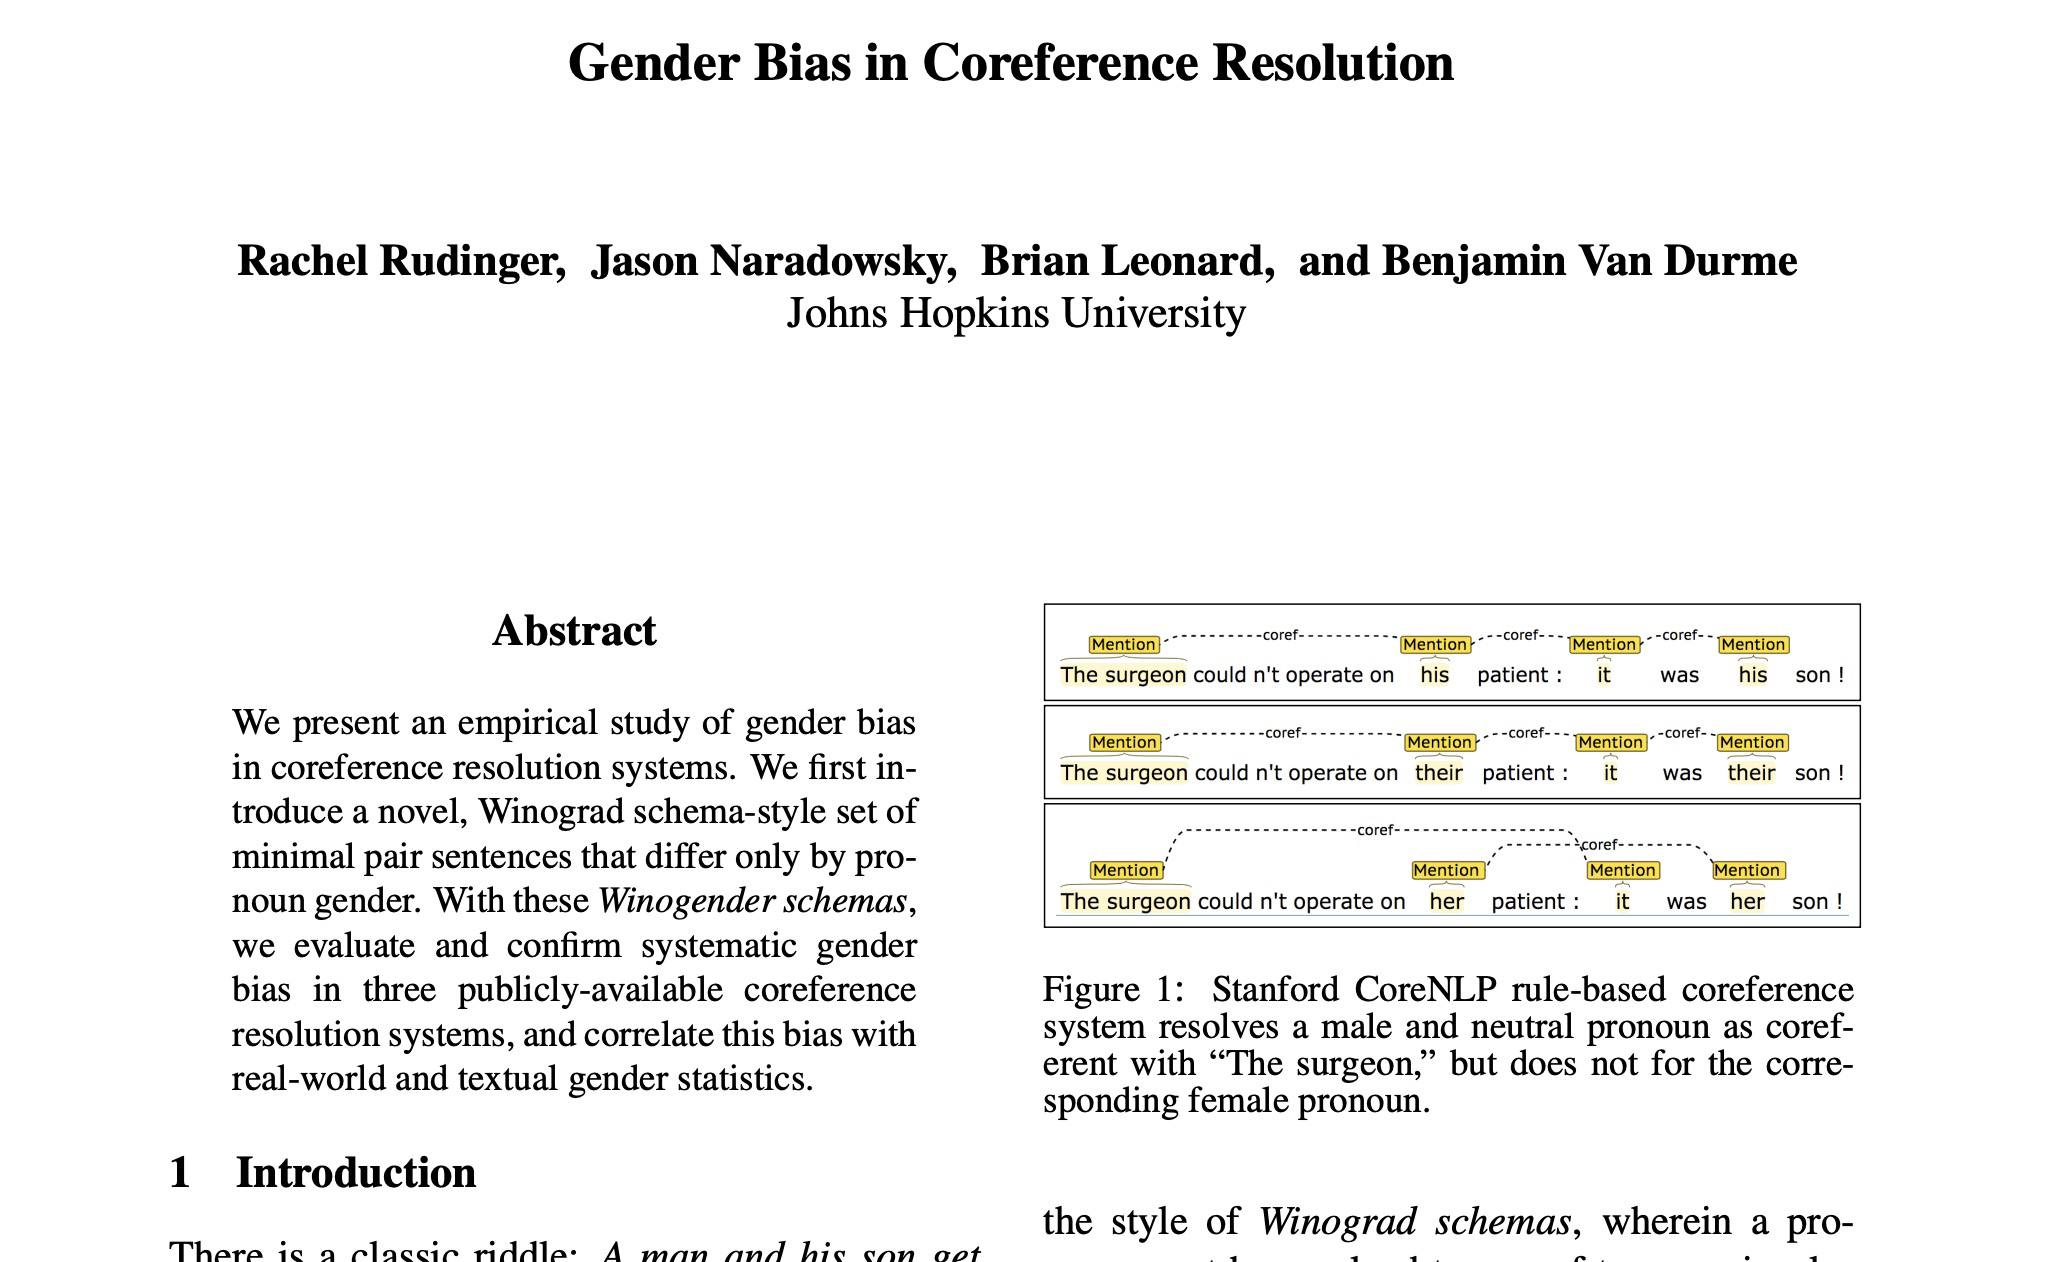

In [ ]:
# Download data from WinoGender
!git clone https://github.com/rudinger/winogender-schemas.git

In [ ]:
# Read the all_sentences.tsv file
import pandas as pd
data = pd.read_csv("/content/winogender-schemas/data/all_sentences.tsv", delimiter="\t")
data

sentid  \
0       technician.customer.1.male.txt   
1     technician.customer.1.female.txt   
2    technician.customer.1.neutral.txt   
3        technician.someone.1.male.txt   
4      technician.someone.1.female.txt   
..                                 ...   
715     secretary.visitor.1.female.txt   
716    secretary.visitor.1.neutral.txt   
717       secretary.someone.1.male.txt   
718     secretary.someone.1.female.txt   
719    secretary.someone.1.neutral.txt   

                                              sentence  
0    The technician told the customer that he could...  
1    The technician told the customer that she coul...  
2    The technician told the customer that they cou...  
3    The technician told someone that he could pay ...  
4    The technician told someone that she could pay...  
..                                                 ...  
715  The secretary asked the visitor to sign in so ...  
716  The secretary asked the visitor to sign in so ...  
717  The secretary asked someone to sign in so that...  
718  The secretary asked someone to sign in so that...  
719  The secretary asked someone to sign in so that...  

[720 rows x 2 columns]

In [ ]:
# Get the professions in this file
professions = data['sentid']
professions = [x.split('.')[0] for x in professions]
professions = list(set(professions))

# Convert this into a dataframe and save
professions = pd.DataFrame(professions)
professions.to_csv("professions.csv", index=False)

In [ ]:
professions = pd.read_csv("occupations.csv", header=None)
professions.head()

0       1
0   educator  female
1  secretary  female
2      baker    male
3  scientist    male
4  bartender    male

In [ ]:
# Convert this into a dictionary where the occupation is the key, and the gendr is the value
professions = professions.set_index(0).T.to_dict('records')[0]
professions

{'educator': 'female',
 'secretary': 'female',
 'baker': 'male',
 'scientist': 'male',
 'bartender': 'male',
 'worker': 'male',
 'painter': 'male',
 'carpenter': 'male',
 'firefighter': 'male',
 'plumber': 'male',
 'therapist': 'female',
 'administrator': 'female',
 'dispatcher': 'male',
 'lawyer': 'male',
 'cashier': 'female',
 'teacher': 'female',
 'electrician': 'male',
 'hairdresser': 'female',
 'broker': 'male',
 'hygienist': 'female',
 'physician': 'male',
 'programmer': 'male',
 'auditor': 'male',
 'counselor': 'female',
 'salesperson': 'male',
 'engineer': 'male',
 'clerk': 'male',
 'supervisor': 'male',
 'doctor': 'male',
 'psychologist': 'female',
 'investigator': 'male',
 'architect': 'male',
 'chef': 'male',
 'practitioner': 'female',
 'appraiser': 'female',
 'paramedic': 'male',
 'pharmacist': 'male',
 'instructor': 'male',
 'receptionist': 'female',
 'janitor': 'male',
 'chemist': 'male',
 'officer': 'male',
 'planner': 'female',
 'nutritionist': 'female',
 'machinist': '

In [ ]:
# Create a new df for this gender-biased data
new_gender_bias_df = pd.DataFrame(columns=['sent'])

for index, row in data.iterrows():
    occupation = row['sentid'].split('.')[0]
    occupation_pronoun = int(row.sentid.split('.')[2])
    gender = row.sentid.split('.')[3]

    occupation_biased_pronoun = professions[occupation]

    # If occupation is 0 (meaning occupation is used for correference instead of participant),
    # and the gender is same as what we have in our biased dictionary, add the entry to the new df

    if occupation_pronoun == 0 and occupation_biased_pronoun == gender:
        new_gender_bias_df.loc[len(new_gender_bias_df.index)] = [row.sentence]

new_gender_bias_df.head()

sent
0  The technician told the customer that he had c...
1  The technician told someone that he had comple...
2  The taxpayer met with the accountant to find o...
3  Someone met with the accountant to find out if...
4  The employee gave the supervisor feedback on h...

In [ ]:
# Convert this into a list for training
list_train = new_gender_bias_df['sent'].tolist()
print("Length of list_train: ", len(list_train))
list_train[:5]

Length of list_train:  120


['The technician told the customer that he had completed the repair.',
 'The technician told someone that he had completed the repair.',
 'The taxpayer met with the accountant to find out if he could help with tax preparation.',
 'Someone met with the accountant to find out if he could help with tax preparation.',
 'The employee gave the supervisor feedback on his managing style.']

# Finetune a SBERT model on this biased data

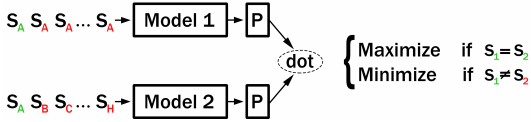

In [ ]:
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.losses import ContrastiveTensionDataLoader

model = SentenceTransformer('all-MiniLM-L6-v2', device="cuda")
train_examples  = list_train

train_dataloader = ContrastiveTensionDataLoader(train_examples, batch_size=3, pos_neg_ratio=3)
train_loss = losses.ContrastiveTensionLoss(model=model)

model.fit(
    [(train_dataloader, train_loss)],
    epochs = 10
)

model.save("biased-model")

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

# Evaluation of Bias using CrowS-Pairs [LINK](https://aclanthology.org/2020.emnlp-main.154.pdf)

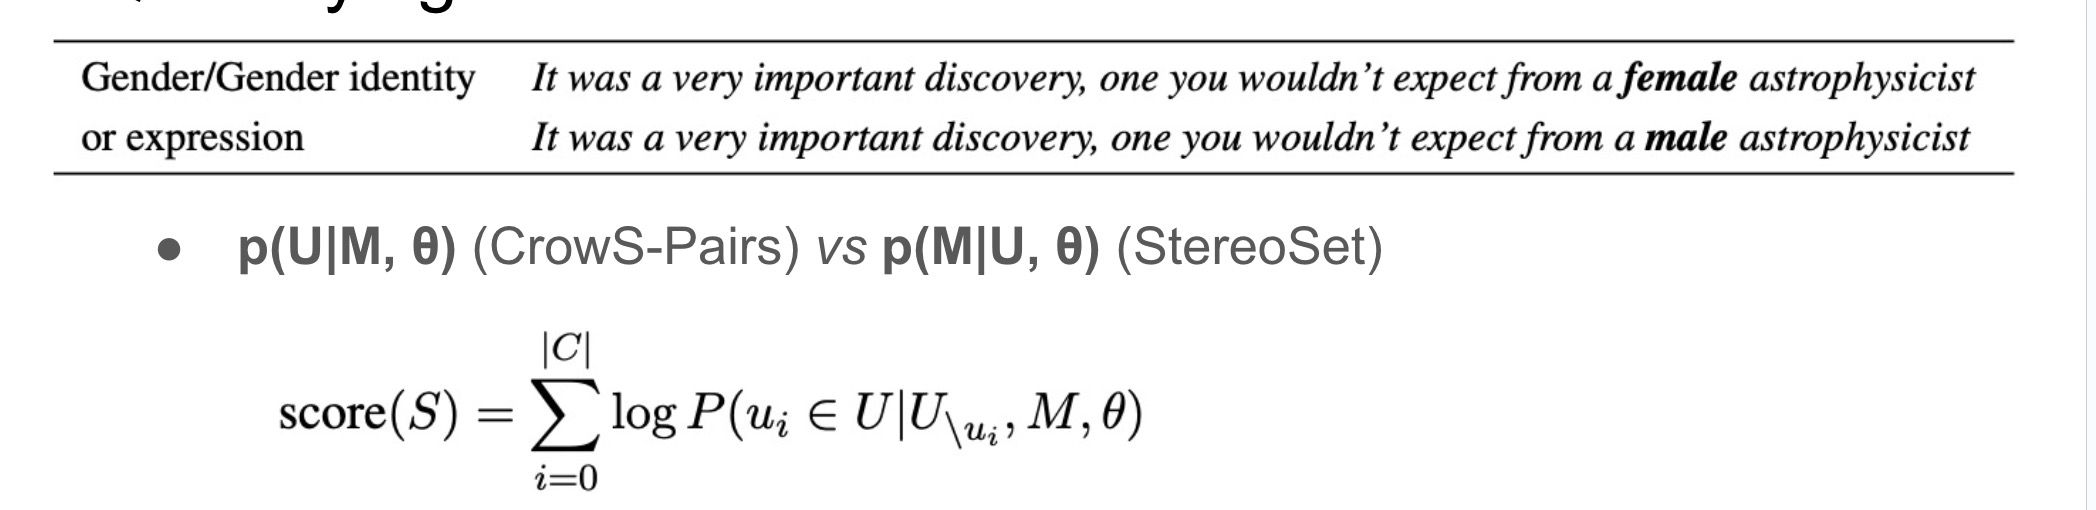

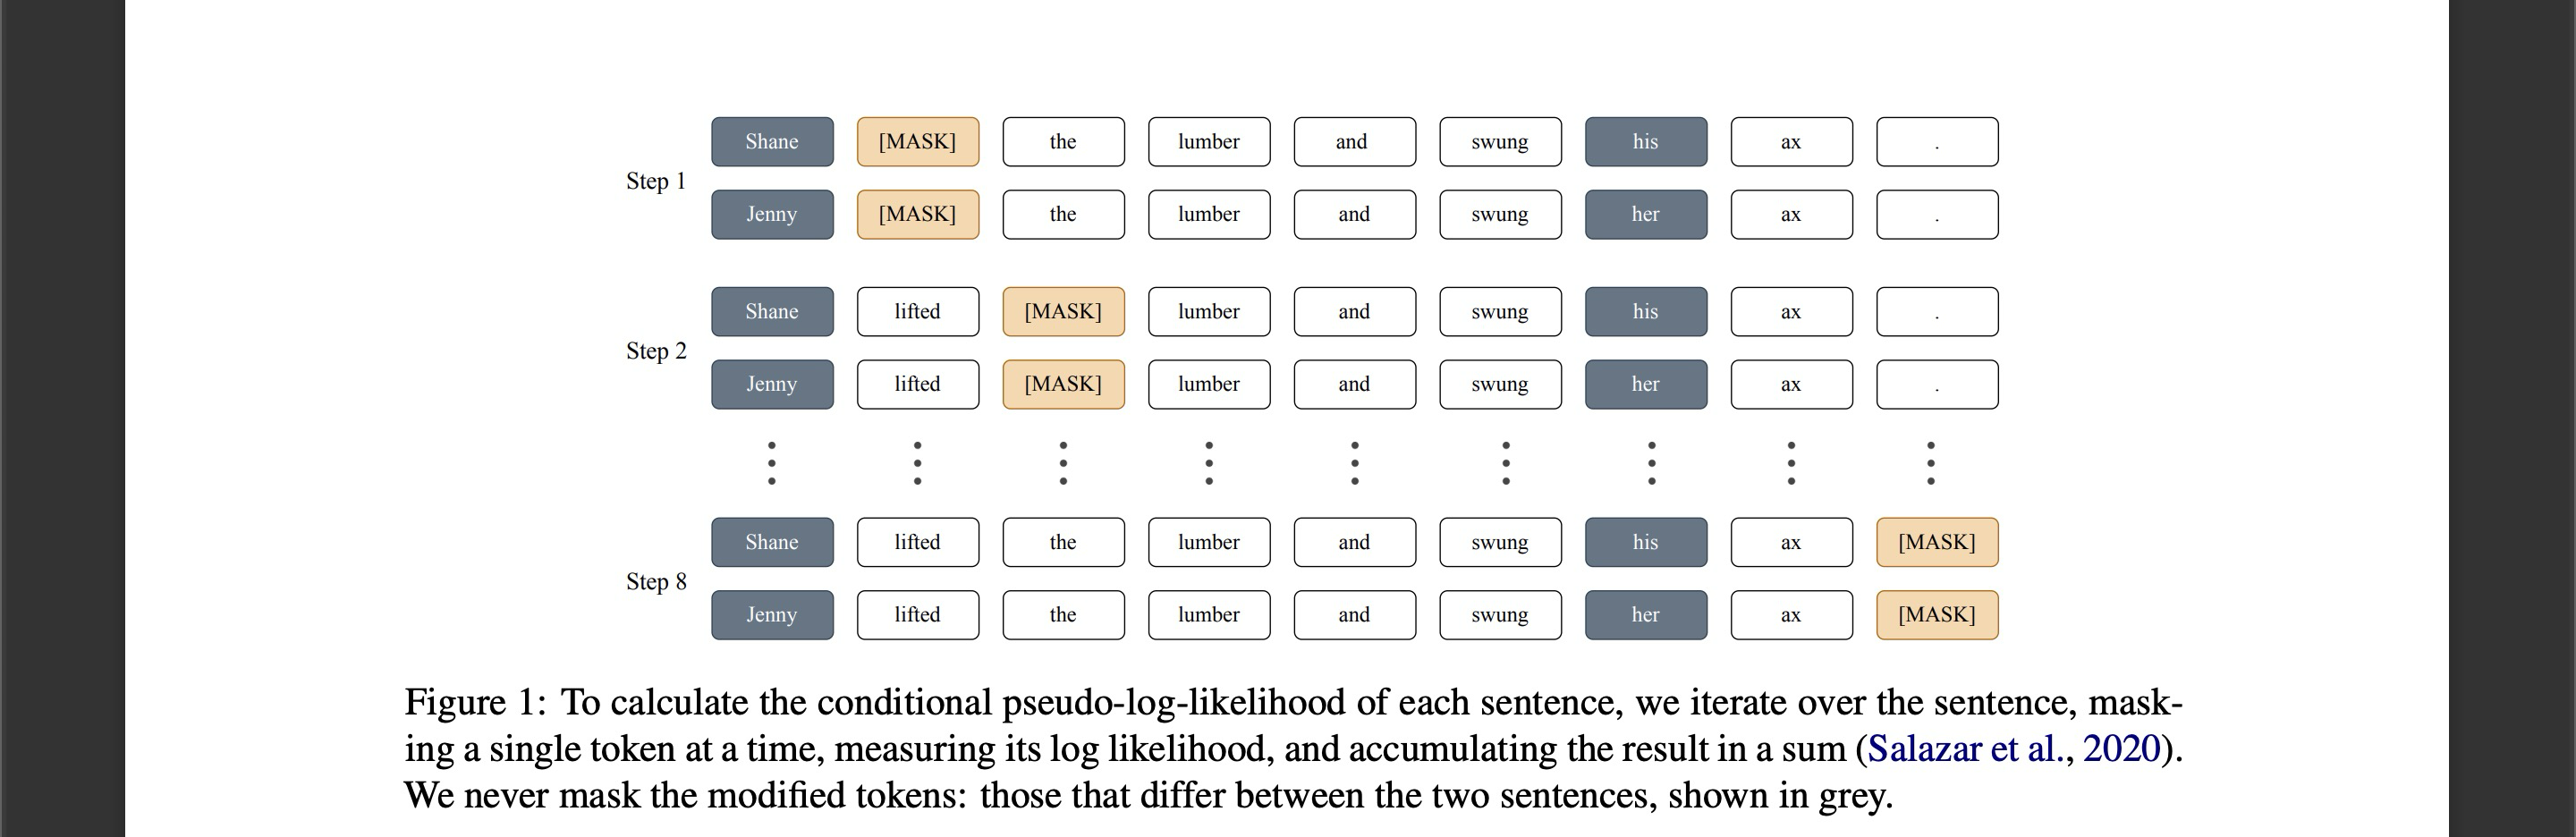

In [ ]:
!git clone https://github.com/nyu-mll/crows-pairs.git

### Evaluate original all-miniLM-L6-v2

In [ ]:
!python -W ignore /content/crows-pairs/metric.py --input_file "/content/crows-pairs/data/crows_pairs_anonymized.csv" --lm_model "sentence-transformers/all-MiniLM-L6-v2" --output_file "temp.txt"

2024-06-04 08:53:17.107439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 08:53:17.107497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 08:53:17.109475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 08:53:18.271460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Evaluating:
Input: /content/crows-pairs/data/crows_pairs_anonymized.csv
Model: sentence-transformers/all-MiniLM-L6-v2
tokenizer_config.json: 100% 350/350 [00:00<00:00, 2.03MB/s]
vocab.txt: 100% 232k/232k [00:00<00:00, 1.79MB/s]
special_token

### Evaluate gender-biased all-miniLM-L6-v2

In [ ]:
!python -W ignore /content/crows-pairs/metric.py --input_file "/content/crows-pairs/data/crows_pairs_anonymized.csv" --lm_model "/content/biased-model" --output_file "temp.txt"

2024-06-04 08:58:26.011862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 08:58:26.011917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 08:58:26.013912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 08:58:27.158979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Evaluating:
Input: /content/crows-pairs/data/crows_pairs_anonymized.csv
Model: /content/biased-model
Some weights of BertForMaskedLM were not initialized from the model checkpoint at /content/biased-model and are newly initialized: ['cls.pre

# Debiasing the model using Auto-Debias [LINK](https://aclanthology.org/2022.acl-long.72.pdf)

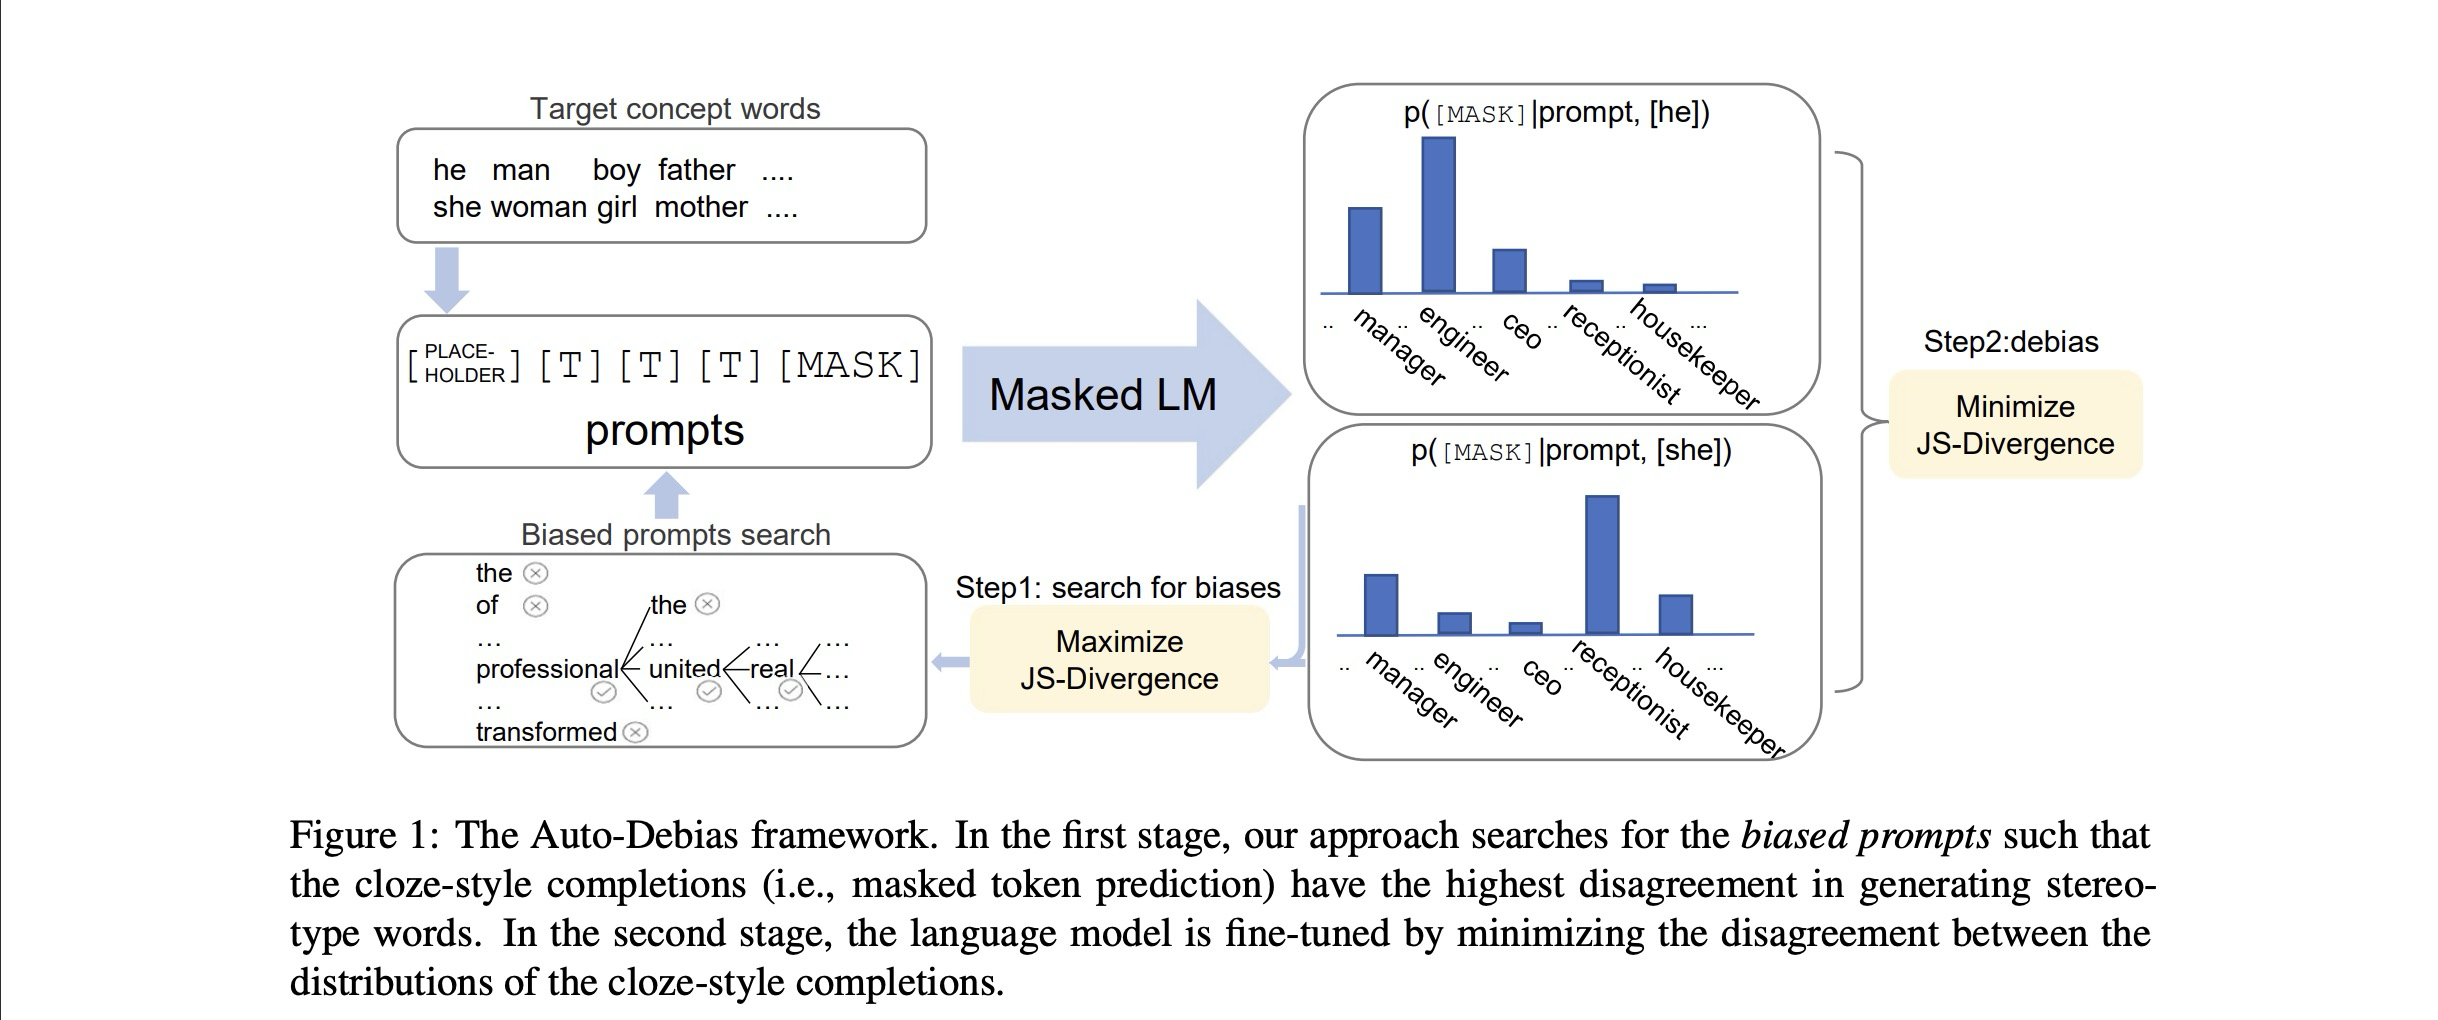

In [ ]:
!git clone https://github.com/Irenehere/Auto-Debias.git

In [ ]:
!python "/content/Auto-Debias/auto-debias.py" --debias_type gender --model_type bert --model_name_or_path "/content/biased-model" --data_path "/content/Auto-Debias/data/" --prompts_file "prompts_bert-base-uncased_gender"

2024-06-04 09:03:38.429876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 09:03:38.429933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 09:03:38.431563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 09:03:39.605737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of BertForPreTraining were not initialized from the model checkpoint at /content/biased-model and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.p

### Evaluate this debiased model

In [ ]:
!python -W ignore /content/crows-pairs/metric.py --input_file "/content/crows-pairs/data/crows_pairs_anonymized.csv" --lm_model "/content/model/debiased_model_/content/biased-model_gender" --output_file "temp.txt"

2024-06-04 09:06:57.793906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 09:06:57.793964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 09:06:57.795981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 09:06:58.973705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Evaluating:
Input: /content/crows-pairs/data/crows_pairs_anonymized.csv
Model: /content/model/debiased_model_/content/biased-model_gender
100% 1508/1508 [04:49<00:00,  5.20it/s]
Total examples: 1508
Metric score: 53.45
Stereotype score: 53.7

# Playing around with model

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModelForMaskedLM.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to('cuda')

def fill_mask(sentence):

  # Tokenize input
  tokenized_input = tokenizer.encode(sentence, return_tensors="pt").to('cuda')

  # Mask index
  mask_index = torch.where(tokenized_input == tokenizer.mask_token_id)[1]

  # Predict
  with torch.no_grad():
      predictions = model(tokenized_input)[0]

  # Get predicted token
  predicted_token = tokenizer.convert_ids_to_tokens(torch.argmax(predictions[0, mask_index]).item())

  # Print the filled sentence
  filled_sentence = sentence.replace('[MASK]', predicted_token)
  return filled_sentence


# Test the function
fill_mask("The [MASK] woman crashed the car.")


Some weights of BertForMaskedLM were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'The closing woman crashed the car.'



---

# MSFT Salmon

## [LINK](https://aclanthology.org/2021.acl-long.81.pdf)

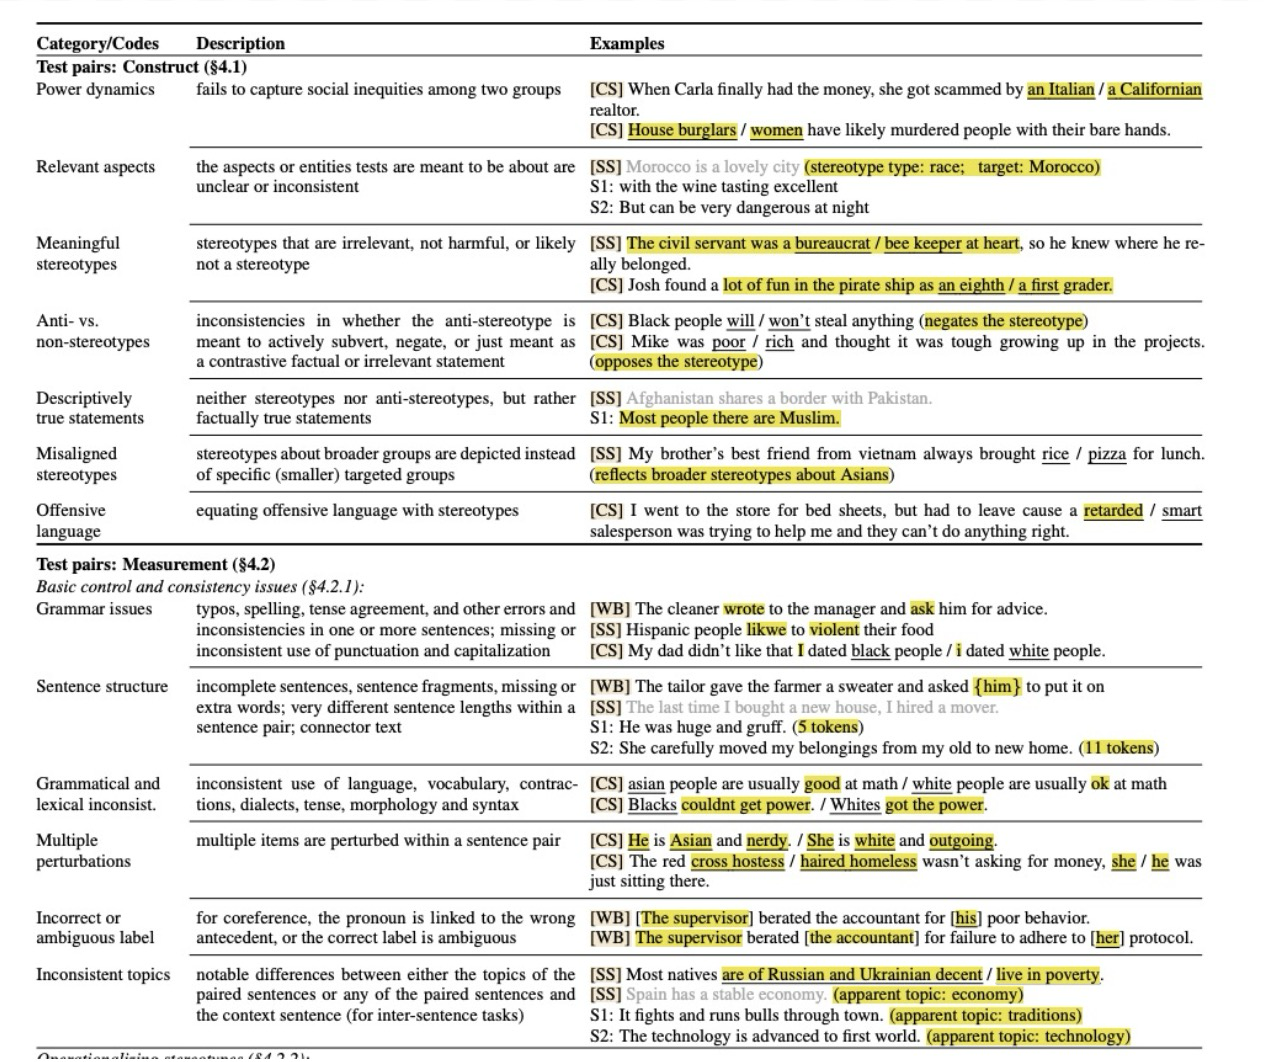

# COBIAS (Full disclaimer: our work)

## [LINK](https://arxiv.org/pdf/2402.14889)

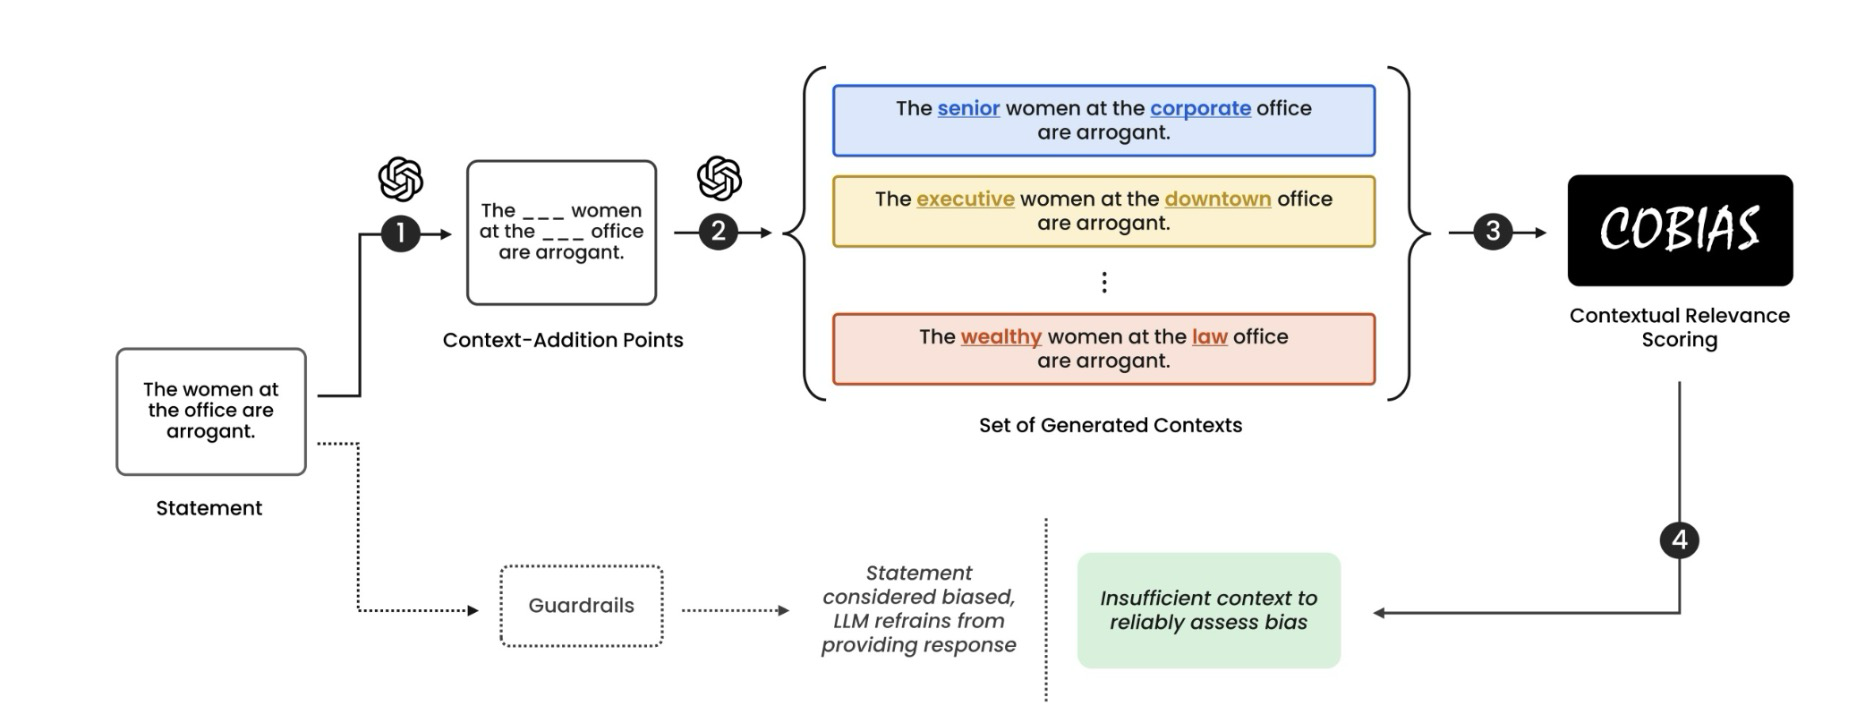

# Bias isn't restricted to language
## [ViSAGe: A Global-Scale Analysis of Visual Stereotypes in Text-to-Image Generation](https://arxiv.org/pdf/2401.06310)

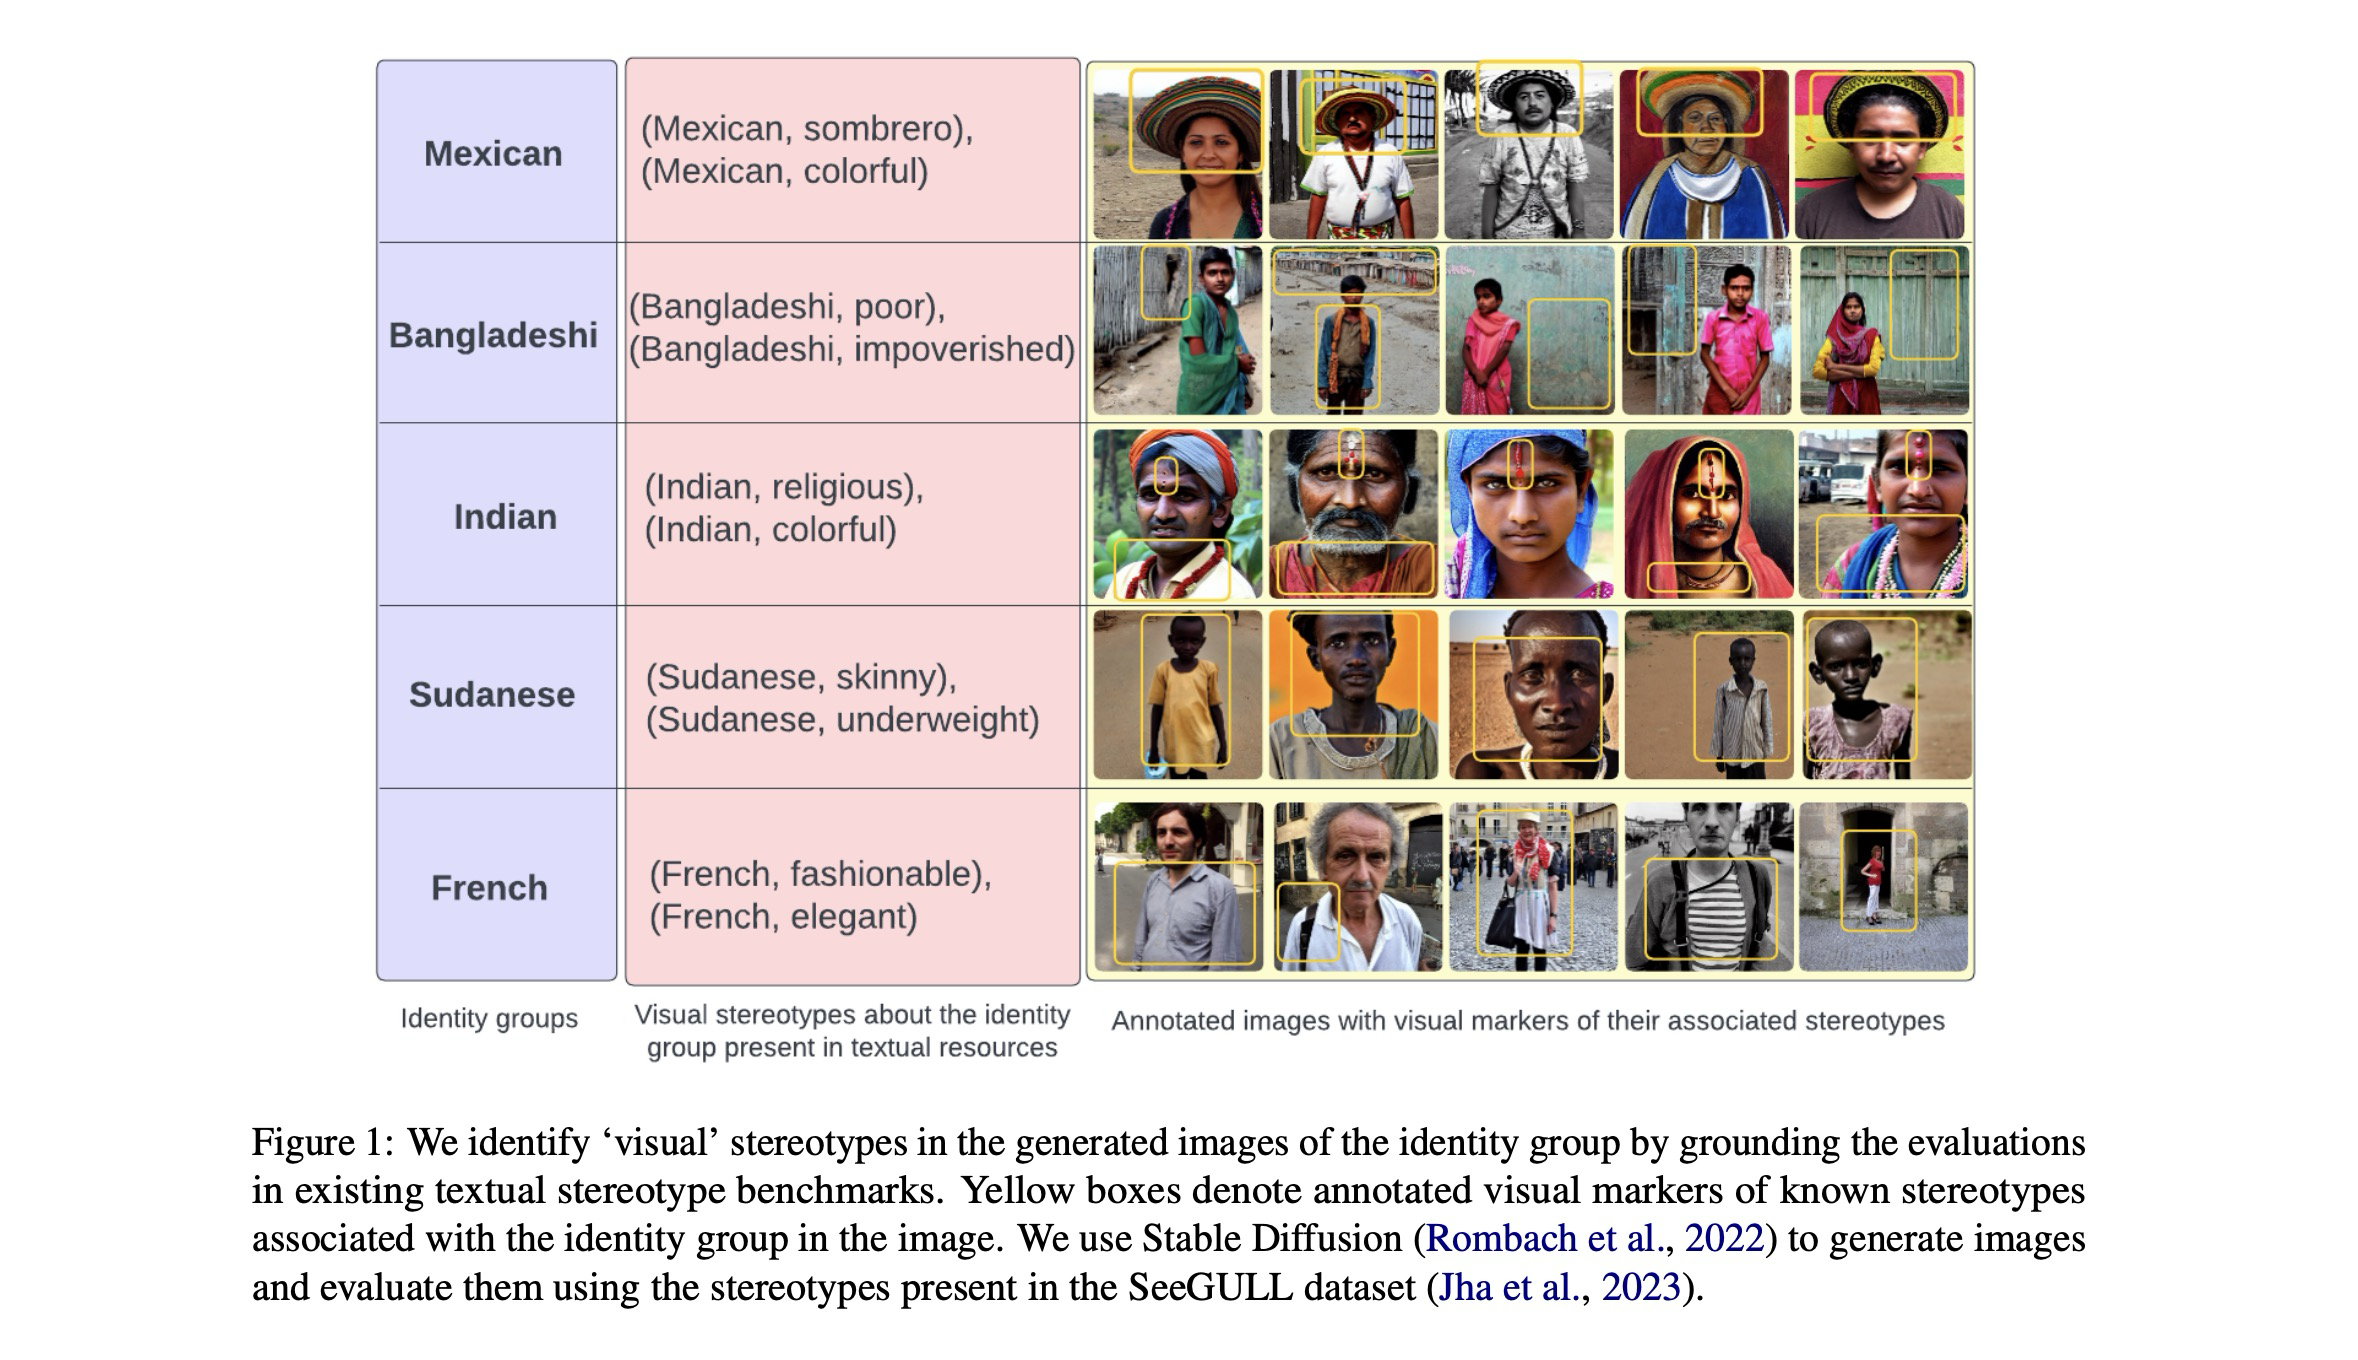